# Initial Rutgers exploration

In [1]:
%reload_ext autoreload
%autoreload 2

import itertools as it
import multiprocessing as mp
from typing import List, Tuple, Generator, Iterator

import numpy as np
import scipy as sp
from scipy import stats, optimize

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

import sklearn as skl
import ipywidgets as widgets
from ipywidgets import interact
from pprint import pprint
import joblib

SEED = 0x1234
np.random.seed(SEED)
np.set_printoptions(suppress=True)

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 3)

plt.style.use(['science', 'notebook'])

memory = joblib.Memory(location='.cache', verbose=0)

# Constants
TX_POWER = 10.0 # dBm
RSSI_BASE = -95.0 # dBm; not sure for this one. Most of the Atheros' have -95
FREQ = 2450.0 # MHz

In [2]:
# Obtain dataset
from datasets.trace1_Rutgers.transform import get_traces, dtypes
from datasets.trace1_Rutgers import NOISE_SOURCES

coords = Tuple[float, float]

# Tools:
def format_axes(ax, SPINE_COLOR='gray', despine=False):
    if despine:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        

    for spine in ['left', 'bottom', 'top', 'right']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    #ax.xaxis.set_ticks_position('bottom')
    #ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

def ensure_dir(path: str):
    from pathlib import Path
    _path = Path(path)
    _path.parent.mkdir(parents=True, exist_ok=True)
    return path

def get_distance(points: Tuple[coords,coords]) -> float:
    assert len(points) == 2, 'Require exactly 2 points to calculate distance'
    (x1, y1), (x2, y2) = points
    d = np.sqrt(np.power(x2 - x1, 2) + np.power(y2 - y1, 2))
    return d

def dbm2mw(value: float) -> float:
    return 0.001 * np.power(10, value / 10.)

def mw2dbm(value: float) -> float:
    return 10. * np.log10(value / 0.001)

def rssi2rss(rssi):
    return rssi + RSSI_BASE

@memory.cache
def get_rutgers_datapoints() -> pd.DataFrame:
    def name2coords(name: str) -> Tuple[float, float]:
        part = name[len('node'):] # extract only numeric part 'node3-2' -> '3-2'
        coords = [float(i) for i in part.split('-')]
        return tuple(coords)
    
    df = []
    
    for trace in get_traces():
        src = trace['src'].values[0]
        dst = trace['dst'].values[0]
        noise = trace['noise'].values[0]

        # Fix names
        src = name2coords(src)
        dst = name2coords(dst)

        trace.src = trace.src.apply(name2coords)
        trace.dst = trace.dst.apply(name2coords)

        # Split column, row
        trace['srcRow'], trace['srcCol'] = src
        trace['dstRow'], trace['dstCol'] = dst

        # Preserve sequence number
        trace['seq'] = trace.index

        trace['rss'] = trace.rssi + RSSI_BASE

        trace['d'] = trace[['src', 'dst']].apply(get_distance, axis=1)

        df.append(trace)
        
    df = pd.concat(df, ignore_index=True)
    return df

Show 10 random samples from the whole dataset.

In [3]:
get_rutgers_datapoints().sample(n=10, random_state=SEED)

,rssi,received,error,seq,noise,src,dst,srcRow,srcCol,dstRow,dstCol,rss,d
125577,0,False,False,177,-10,"(5.0, 6.0)","(1.0, 4.0)",5.0,6.0,1.0,4.0,-95.0,4.472
156939,0,False,False,39,-10,"(6.0, 7.0)","(8.0, 1.0)",6.0,7.0,8.0,1.0,-95.0,6.325
657373,0,False,False,73,-20,"(5.0, 6.0)","(6.0, 1.0)",5.0,6.0,6.0,1.0,-95.0,5.099
858876,0,False,False,276,-5,"(5.0, 6.0)","(1.0, 6.0)",5.0,6.0,1.0,6.0,-95.0,4.000
175641,15,True,False,141,-10,"(8.0, 3.0)","(7.0, 6.0)",8.0,3.0,7.0,6.0,-80.0,3.162
1051788,8,True,False,288,-15,"(1.0, 2.0)","(1.0, 6.0)",1.0,2.0,1.0,6.0,-87.0,4.000
1075047,0,False,False,147,-15,"(8.0, 1.0)","(5.0, 8.0)",8.0,1.0,5.0,8.0,-95.0,7.616
608505,0,False,False,105,-20,"(7.0, 4.0)","(1.0, 8.0)",7.0,4.0,1.0,8.0,-95.0,7.211
133045,10,True,False,145,-10,"(5.0, 8.0)","(6.0, 3.0)",5.0,8.0,6.0,3.0,-85.0,5.099
319869,0,False,False,69,0,"(1.0, 8.0)","(7.0, 4.0)",1.0,8.0,7.0,4.0,-95.0,7.211


The code below will transform datapoints and generate new features

In [4]:
@memory.cache
def produce_dataset(Wprr:int=10, Wh:int=10, predict_ahead:int=1) -> pd.DataFrame:
    
    assert isinstance(Wprr, int)
    assert isinstance(Wh, int)
    assert isinstance(predict_ahead, int)
    
    def name2coords(name: str) -> Tuple[float, float]:
        part = name[len('node'):] # extract only numeric part 'node3-2' -> '3-2'
        coords = [float(i) for i in part.split('-')]
        return tuple(coords)
    
    df = []
    
    for trace in get_traces():
        src = trace['src'].values[0]
        dst = trace['dst'].values[0]
        noise = trace['noise'].values[0]

        # Fix names
        src = name2coords(src)
        dst = name2coords(dst)

        trace.src = trace.src.apply(name2coords)
        trace.dst = trace.dst.apply(name2coords)

        # Split column, row
        trace['srcRow'], trace['srcCol'] = src
        trace['dstRow'], trace['dstCol'] = dst

        # Preserve sequence number
        trace['seq'] = trace.index

        trace['rss'] = trace.rssi + RSSI_BASE

        trace['d'] = trace[['src', 'dst']].apply(get_distance, axis=1)
        
        trace['meanRSSI'] = trace.rssi.rolling(window=Wh).mean()
        trace['medianRSSI'] = trace.rssi.rolling(window=Wh).median()
        trace['stdRSSI'] = trace.rssi.rolling(window=Wh).std()
        
        trace['PRR'] = trace.received.rolling(window=Wprr).sum() / Wprr
        
        for i in range(1, predict_ahead+1):
            trace[f'PRR+{i}'] = trace.PRR.shift(-Wprr * predict_ahead)

        df.append(trace)
        
    df = pd.concat(df, ignore_index=True)
    return df
    
produce_dataset().head(20)

,rssi,received,error,seq,noise,src,dst,srcRow,srcCol,dstRow,dstCol,rss,d,meanRSSI,medianRSSI,stdRSSI,PRR,PRR+1
0,14,True,False,0,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-81.0,5.099,NaN,NaN,NaN,NaN,1.0
1,11,True,False,1,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-84.0,5.099,NaN,NaN,NaN,NaN,1.0
2,7,True,False,2,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-88.0,5.099,NaN,NaN,NaN,NaN,1.0
3,6,True,False,3,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-89.0,5.099,NaN,NaN,NaN,NaN,1.0
4,5,True,False,4,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-90.0,5.099,NaN,NaN,NaN,NaN,1.0
5,8,True,False,5,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-87.0,5.099,NaN,NaN,NaN,NaN,1.0
6,4,True,False,6,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-91.0,5.099,NaN,NaN,NaN,NaN,1.0
7,8,True,False,7,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-87.0,5.099,NaN,NaN,NaN,NaN,1.0
8,6,True,False,8,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-89.0,5.099,NaN,NaN,NaN,NaN,1.0
9,6,True,False,9,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-89.0,5.099,7.5,6.5,2.991,1.0,1.0


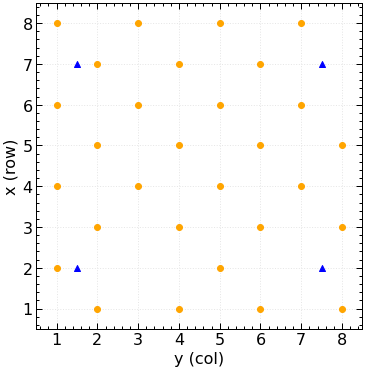

In [5]:
def plot_map():
    dataset = get_rutgers_datapoints()
    
    noise_generator_positions = pd.DataFrame(data=list(NOISE_SOURCES), columns=['row', 'col'])
    noise_generator_positions['type'] = 'interference'

    known_nodes = dataset.src.append(dataset.dst, ignore_index=True).unique().tolist()
    known_nodes = pd.DataFrame(data=known_nodes, columns=['row', 'col'])
    known_nodes['type'] = 'node'

    positions = pd.concat([noise_generator_positions, known_nodes], ignore_index=True).reset_index(drop=True)

    
    f, ax = plt.subplots()
    
    ax.grid(which='major', color='0.9', linestyle=':')
    ax.set_aspect('equal', 'box')

    ax.scatter(data=positions[positions.type=='node'], x='col', y='row', c='orange', zorder=2)
    ax.scatter(data=positions[positions.type=='interference'], x='col', y='row', marker='^', c='blue', zorder=2)

    ax.invert_yaxis()

    ax.set_xticks(np.arange(1, 9, 1))
    ax.set_yticks(np.arange(1, 9, 1))
    
    ax.set_xlim([.5, 8.5])
    ax.set_ylim([.5, 8.5])
    
    ax.set_ylabel('x (row)')
    ax.set_xlabel('y (col)')

    plt.show(f)
    plt.close(f)
    
    return f, ax
    
plot_map();

The above figure shows positions of transcievers (orange dots) and interference generators (blue triangle).

,rssi,seq,noise,srcRow,srcCol,dstRow,dstCol,rss,d
count,300.000,300.000,300.0,300.0,300.0,300.0,300.0,300.000,3.000e+02
mean,2.823,149.500,0.0,2.0,1.0,7.0,6.0,-92.177,7.071e+00
std,1.678,86.747,0.0,0.0,0.0,0.0,0.0,1.678,3.559e-14
min,0.000,0.000,0.0,2.0,1.0,7.0,6.0,-95.000,7.071e+00
25%,2.000,74.750,0.0,2.0,1.0,7.0,6.0,-93.000,7.071e+00
50%,3.000,149.500,0.0,2.0,1.0,7.0,6.0,-92.000,7.071e+00
75%,4.000,224.250,0.0,2.0,1.0,7.0,6.0,-91.000,7.071e+00
max,6.000,299.000,0.0,2.0,1.0,7.0,6.0,-89.000,7.071e+00


,rssi,received,error,seq,noise,src,dst,srcRow,srcCol,dstRow,dstCol,rss,d
360595,4,True,False,295,0,"(2.0, 1.0)","(7.0, 6.0)",2.0,1.0,7.0,6.0,-91.0,7.071
360596,4,True,False,296,0,"(2.0, 1.0)","(7.0, 6.0)",2.0,1.0,7.0,6.0,-91.0,7.071
360597,4,True,False,297,0,"(2.0, 1.0)","(7.0, 6.0)",2.0,1.0,7.0,6.0,-91.0,7.071
360598,3,True,False,298,0,"(2.0, 1.0)","(7.0, 6.0)",2.0,1.0,7.0,6.0,-92.0,7.071
360599,3,True,False,299,0,"(2.0, 1.0)","(7.0, 6.0)",2.0,1.0,7.0,6.0,-92.0,7.071


<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 360300 to 360599
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rssi      300 non-null    uint8  
 1   received  300 non-null    bool   
 2   error     300 non-null    bool   
 3   seq       300 non-null    int64  
 4   noise     300 non-null    int8   
 5   src       300 non-null    object 
 6   dst       300 non-null    object 
 7   srcRow    300 non-null    float64
 8   srcCol    300 non-null    float64
 9   dstRow    300 non-null    float64
 10  dstCol    300 non-null    float64
 11  rss       300 non-null    float64
 12  d         300 non-null    float64
dtypes: bool(2), float64(6), int64(1), int8(1), object(2), uint8(1)
memory usage: 24.6+ KB


None

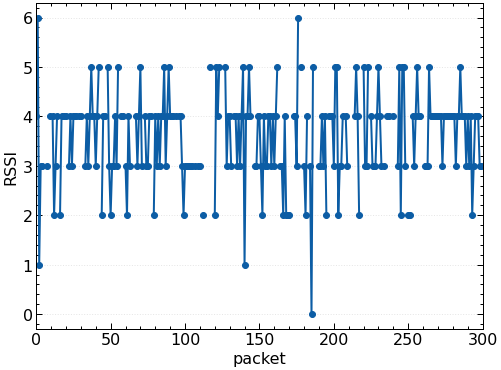

In [6]:
df = get_rutgers_datapoints()
link = df.loc[(df.src==(2,1)) & (df.dst==(7,6)) & (df.noise==0)].copy()

display(link.describe())
display(link.tail())
display(link.info())

link.loc[~link.received, 'rssi'] = np.nan

f, ax = plt.subplots()
ax.plot('seq', 'rssi', '-o', data=link)
ax.set_xlim(0, 300)
ax.set_ylabel('RSSI')
ax.set_xlabel('packet')
ax.grid(axis='y', color='0.9', linestyle=':')

plt.show()
plt.close(f)

del link, df

The above picture present a single link selected to present a link with a few missing values. See the range between 100 and 125.

In [7]:
# Labels/classes used throughout the paper and code.
labels = ('good', 'interm.', 'bad')

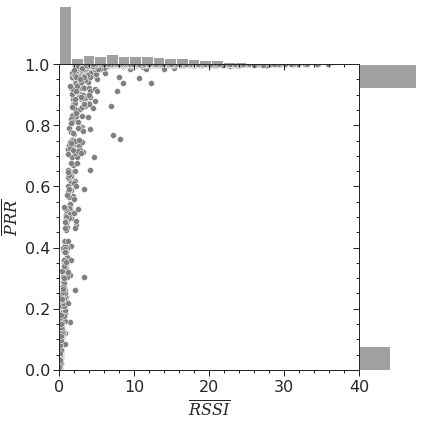

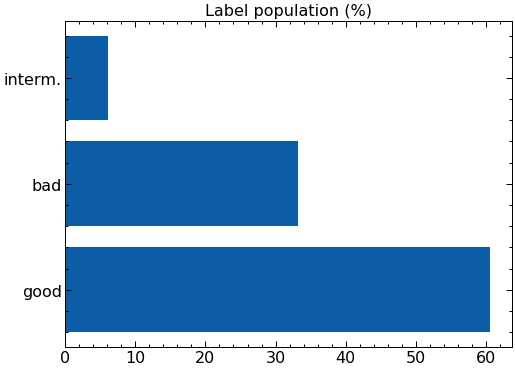

In [8]:
from collections import Counter

df = produce_dataset()

def set_class(value):
    if np.isnan(value): return None
    if value >= 0.9: return 'good'
    if value <= 0.1: return 'bad'
    return 'interm.'

def ratio(x): return x.sum() / len(x.index)


data = df.groupby(['src', 'dst', 'noise'], as_index=False) \
    .agg({'rssi': ['mean', 'std'], 'received': ratio})

# Merge multiindex column names
data.columns = data.columns.map('|'.join).str.strip('|')

# Add labels according to common pattern
data['label'] = data['received|ratio'].apply(set_class)

with sns.axes_style('ticks'):
    g = sns.jointplot(
        data=data, 
        x='rssi|mean', 
        y='received|ratio',
        color='.5',
        kind='scatter', # ['scatter', 'hist', 'hex', 'kde', 'reg', 'resid']
        #bins='log',
        xlim=(0, df['rssi'].max()),
        ylim=(0, 1),
        space=0
    )
    g.set_axis_labels('$\overline{RSSI}$', '$\overline{PRR}$')

classes = data['label']

c = Counter(classes)

values = sum(c.values())
for key in c.keys(): # Normalize
    c[key] /= values
    c[key] *= 100
    

f, ax = plt.subplots()
ax.barh(list(c.keys()), list(c.values()))
ax.set_title('Label population (%)')
plt.show(f)
plt.close(f)
    
del c, df, data

The top picture presents relationship between PRR and RSSI|avg as PRR(RSSI|avg). The bottom picture present % of population assigned to each class.

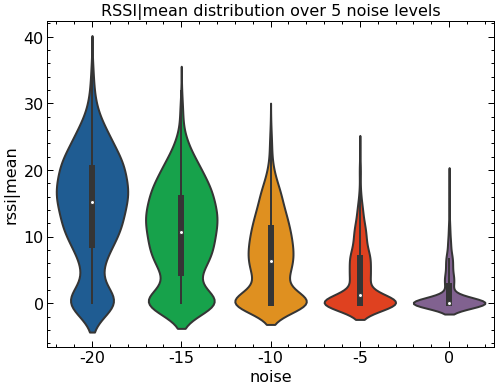

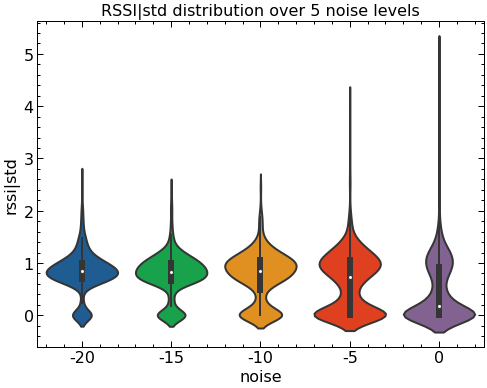

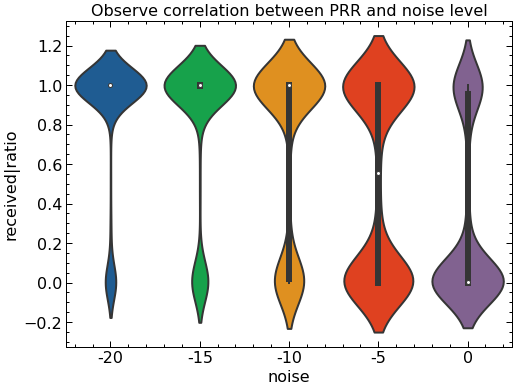

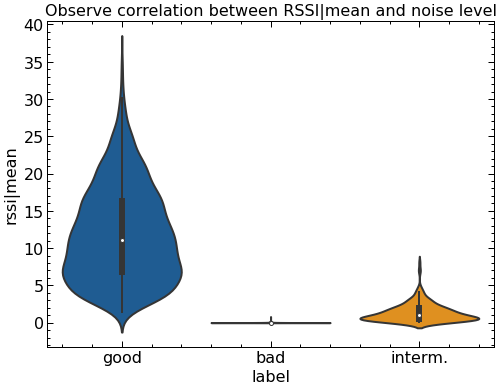

In [9]:
df = produce_dataset()

data = df.groupby(['src', 'dst', 'noise'], as_index=False) \
    .agg({'rssi': ['mean', 'std'], 'received': ratio})

# Merge multiindex column names
data.columns = data.columns.map('|'.join).str.strip('|')

# Add labels according to common pattern
data['label'] = data['received|ratio'].apply(set_class)

plt.title('RSSI|mean distribution over 5 noise levels')
sns.violinplot(data=data, x='noise', y='rssi|mean', scale='width')
plt.show()

plt.title('RSSI|std distribution over 5 noise levels')
sns.violinplot(data=data, x='noise', y='rssi|std', scale='width')
plt.show()

plt.title('Observe correlation between PRR and noise level')
sns.violinplot(data=data, x='noise', y='received|ratio', scale='width')
plt.show()

plt.title('Observe correlation between RSSI|mean and noise level')
sns.violinplot(data=data, x='label', y='rssi|mean', scale='width')
plt.show()

del df, data

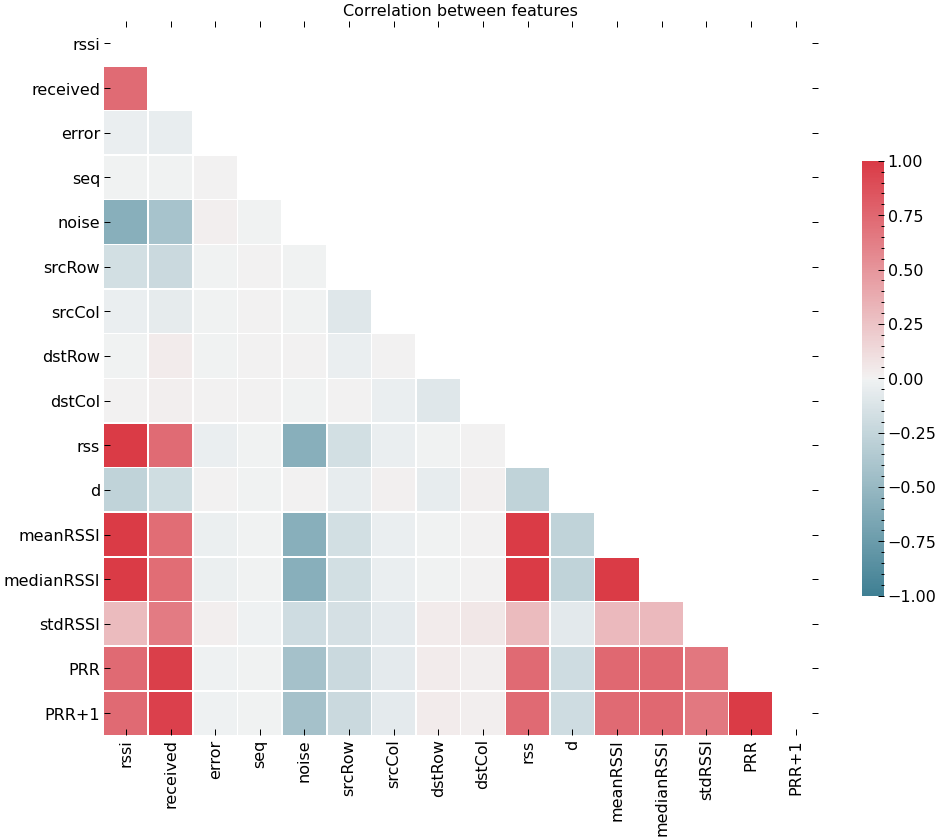

In [10]:
df = produce_dataset(Wprr=10, Wh=10, predict_ahead=1)

corr = df.corr(method='pearson')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(16,16))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.minorticks_off()

ax.set_title('Correlation between features')

plt.show(f)
plt.close(f)

In [11]:
# Introduce polynomial features (handpicked interactions with themself and others)
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
picked_features = ['rssi', 'meanRSSI', 'stdRSSI', 'medianRSSI']

def prr2label(x):
    if x >= 0.9: return 'good'
    if x <= 0.1: return 'bad'
    return 'interm.'

df = produce_dataset(Wprr=20, Wh=20, predict_ahead=1)
df['label'] = df['PRR+1'].apply(prr2label)

df.dropna(subset=picked_features, inplace=True)

X, rest = df.loc[:, picked_features], df.drop(picked_features, axis=1)

poly = PolynomialFeatures(degree=4, include_bias=True).fit(X)

# Next line converts back to pandas, while preserving column names
X = pd.DataFrame(poly.transform(X).astype(np.float32), columns=poly.get_feature_names(X.columns), index=X.index)

df = pd.concat([X, rest], axis=1)

df.info()


tmp = df.drop(['src', 'dst', 'seq', 'error', 'noise', 'label'], axis=1).dropna()
scaler = StandardScaler().fit(tmp)

tmp = pd.DataFrame(
    scaler.transform(tmp).astype(np.float32),
    columns=tmp.columns,
    index=tmp.index, 
)

r2 = []
for column in tmp.columns:
    coef = r2_score(tmp['PRR+1'], tmp[column])
    r2.append([column, coef])

r2 = pd.DataFrame(r2, columns=('feature', 'R^2')).sort_values('R^2', ascending=False)

display(r2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1140860 entries, 19 to 1217999
Data columns (total 85 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   1                                 1140860 non-null  float32
 1   rssi                              1140860 non-null  float32
 2   meanRSSI                          1140860 non-null  float32
 3   stdRSSI                           1140860 non-null  float32
 4   medianRSSI                        1140860 non-null  float32
 5   rssi^2                            1140860 non-null  float32
 6   rssi meanRSSI                     1140860 non-null  float32
 7   rssi stdRSSI                      1140860 non-null  float32
 8   rssi medianRSSI                   1140860 non-null  float32
 9   meanRSSI^2                        1140860 non-null  float32
 10  meanRSSI stdRSSI                  1140860 non-null  float32
 11  meanRSSI medianRSSI               11

,feature,R^2
78,PRR+1,1.000e+00
77,PRR,9.939e-01
70,received,9.390e-01
4,medianRSSI,4.878e-01
2,meanRSSI,4.855e-01
1,rssi,4.780e-01
75,rss,4.780e-01
10,meanRSSI stdRSSI,4.540e-01
13,stdRSSI medianRSSI,4.407e-01
7,rssi stdRSSI,4.217e-01
